<a href="https://colab.research.google.com/github/annisaeka123/Machine_Learning-Semester5/blob/main/JS06/Praktikum5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Praktikum 5

In [1]:
!pip install annoy
!pip install faiss-cpu
!pip install hnswlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551811 sha256=822593dc0c352758f0034d13c42490b687364cf20764c4bce2e9cf2559a07597
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 68.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528143 sha256=85e9b7601b1a951d8ac8a3b3f57f8bbe40c181599ebb161c590bfec6c27f50ee
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built hnswlib


Membangun ground truth (exact search) dengan FAISS...

Menjalankan benchmark Annoy...
Menjalankan benchmark FAISS...
Menjalankan benchmark HNSW...

=== Hasil Benchmark ANN ===
    Model  Parameter  Recall  Query Time (ms/query)
0   Annoy        200  0.0221                 0.0688
1   Annoy        500  0.0453                 0.2010
2   Annoy       1000  0.0772                 0.2000
3   Annoy       2000  0.1331                 0.3729
4   Faiss        200  0.0552                 0.0377
5   Faiss        500  0.1926                 0.1797
6   Faiss       1000  0.3160                 0.3729
7   Faiss       2000  0.4986                 1.0265
8    HNSW        200  0.2997                 0.2432
9    HNSW        500  0.4390                 0.4335
10   HNSW       1000  0.6092                 0.5170
11   HNSW       2000  0.7714                 0.9995


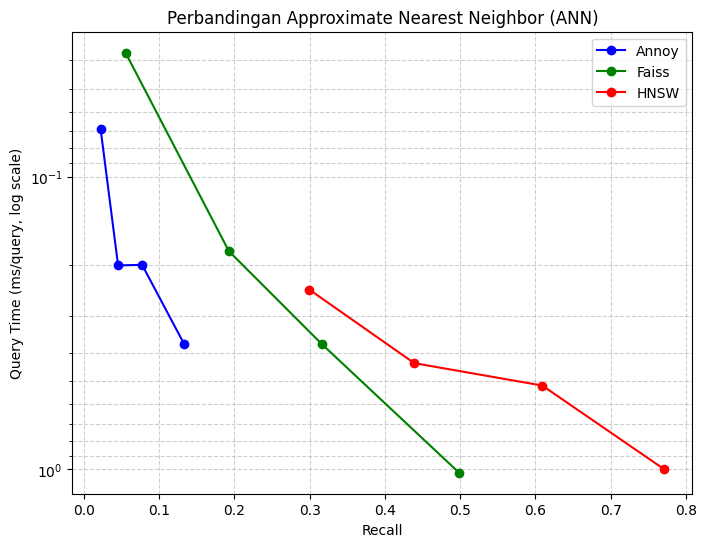

In [2]:
# ============================================================
# JS06 - Praktikum 5
# Approximate Nearest Neighbors (ANN) Benchmark
# ============================================================

import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================
# 1. Dataset Random
# ============================================================
d = 128        # Dimensi vektor
nb = 100000    # Jumlah data (database)
nq = 1000      # Jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

k = 10  # jumlah nearest neighbors

# ============================================================
# 2. Ground Truth menggunakan FAISS Brute Force (Exact Search)
# ============================================================
print("Membangun ground truth (exact search) dengan FAISS...")
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
_, gt_idx = index_flat.search(xq, k)

# ============================================================
# 3. Fungsi Recall
# ============================================================
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# ============================================================
# 4. Benchmark Functions
# ============================================================

# Annoy
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# FAISS (IVF)
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# HNSW
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# ============================================================
# 5. Jalankan Benchmark dengan Beberapa Parameter
# ============================================================
results = {"Annoy": [], "Faiss": [], "HNSW": []}

print("\nMenjalankan benchmark Annoy...")
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

print("Menjalankan benchmark FAISS...")
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

print("Menjalankan benchmark HNSW...")
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

# ============================================================
# 6. Tabel hasil perbandingan (Recall & Query Time)
# ============================================================
rows = []
for model, data in results.items():
    for i, (rec, t) in enumerate(data):
        rows.append({
            "Model": model,
            "Parameter": [200, 500, 1000, 2000, 1, 5, 10, 20, 50, 100, 200, 400][i],
            "Recall": round(rec, 4),
            "Query Time (ms/query)": round(t, 4)
        })

df_results = pd.DataFrame(rows)
print("\n=== Hasil Benchmark ANN ===")
print(df_results)

# ============================================================
# 7. Visualisasi Grafik Recall vs Query Time
# ============================================================
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # semakin cepat = lebih tinggi (dibalik)
plt.title("Perbandingan Approximate Nearest Neighbor (ANN)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()
